In [3]:
using Random, Distributions, LinearAlgebra, Plots

rng = Random.seed!(1234)


ϵ = 1.0e-6  # to help with numerical stability in matrix operations

1.0e-6

In [4]:
function SE_kernel(x, x′; λ=1, ℓ=1)
    return (λ^2) * exp( -(x-x′)^2 / (2*(ℓ^2)) )
end

SE_kernel (generic function with 1 method)

In [5]:
# We separate the calculation of the covariance matrix into two functions to take
# advantage of the symmetry found in covariance matrices to minimize some computation

function self_cov_mat(kernel, X)

    len = length(X)
    K = zeros(len, len)
    for i in 1:len
        for j in i:len
            K[i,j] = kernel(X[i], X[j])
            K[j,i] = K[i,j]
        end
    end
    
    return K + ϵ * I # for numerical stability

end


function cross_cov_mat(kernel, X, X′)
    
    size= length(X)
    size′= length(X′)
    K =zeros(size, size′)
    
    for i in 1:size
        for j in 1:size′
            K[i,j] = kernel(X[i], X′[j])
        end
    end
    
    return K

end

cross_cov_mat (generic function with 1 method)

In [6]:
## Prior
# Here we build a method to draw samples from the prior distribution of our GP.

function sample_prior(xs, num_samples, kernel)

    μ = zeros(length(xs))
    Σ = self_cov_mat(kernel, xs)
    
    ys = rand(MvNormal(μ, Σ), num_samples)

    plot(xs, ys)

end


sample_prior (generic function with 1 method)

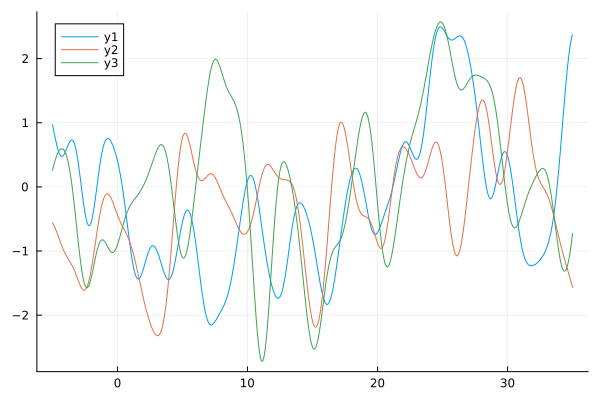

In [7]:
xs = range(-5, 35; length=1000)
sample_prior(xs, 3, SE_kernel)

Intuitively, we can think of each of these samples as a function, and so our GP is just a multivariate Gaussian over the function space.

In [11]:
## Predictive distribution for y*

function predictive_gp(X, y, Xs , kernel)

    KXX = self_cov_mat(kernel, X) 
    KXsX = cross_cov_mat(kernel, Xs, X)
    KXsXs = self_cov_mat(kernel, Xs)
      
    μ_pred = KXsX * inv(KXX) * y
    K_pred = KXsXs - KXsX * inv(KXX) * transpose(KXsX)
    
    return (μ_pred, Symmetric(K_pred))     # Symmetric() required due to some numeric instability
   
end


function sample_predictive(x_train, y_train, x_pred, num_samples, kernel)

    μ, K = predictive_gp(x_train, y_train, x_pred, kernel)
    ys = rand(MvNormal(μ, K), num_samples)
    σs = sqrt.(diag(K))

    return ys, σs

end

sample_predictive (generic function with 1 method)

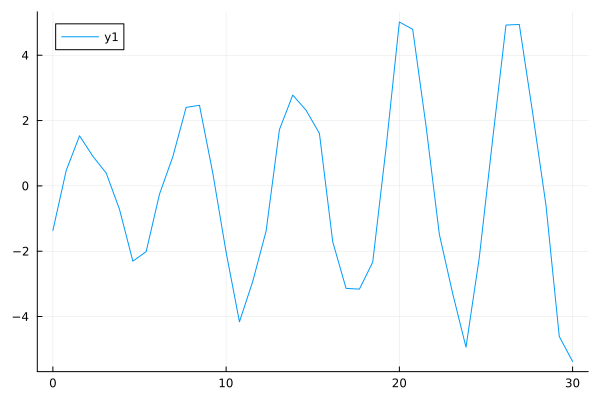

In [25]:
## The Data

# We will start off by making our toy dataset, by adding 
# some noise to a nonlinear function.

num_sample = 40
num_train = 30

x = range(0,30;length=num_sample);
ϵ_data = rand(Normal(0,0.5), num_sample);
y = sqrt.(x).*sin.(x) .+ ϵ_data;
plot(x,y)

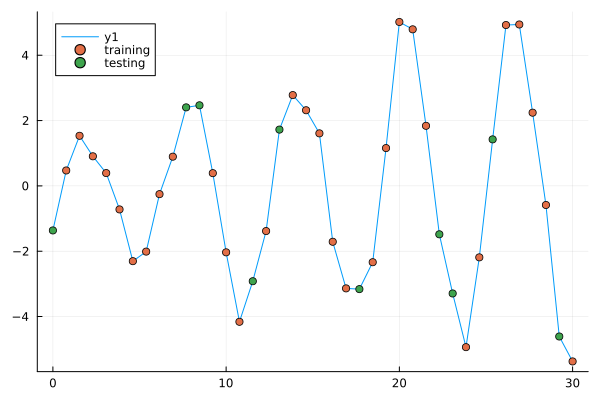

In [26]:
# We now have split our data to isolate some training data, as well as some unseen data. We are
# calling this unseen data "test" data.

indices = randcycle(rng, num_sample)
x_train = zeros(num_train)
y_train = zeros(num_train)
x_test = zeros(num_sample-num_train)
y_test = zeros(num_sample-num_train)

for (i, val) in enumerate(indices)
    if i<=num_train
        x_train[i] = x[val]
        y_train[i] = y[val]
    else
        x_test[i-num_train] = x[val]
        y_test[i-num_train] = y[val]
    end
end
scatter!(x_train ,y_train,label="training")
scatter!(x_test ,y_test,label="testing")

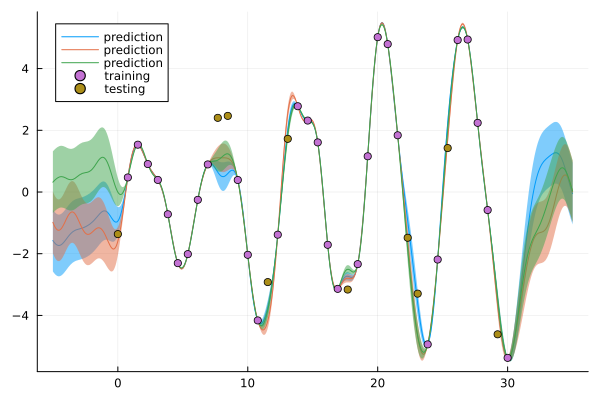

In [27]:
# now, run our model and make 'predictions'
x_pred = range(-5, 35; length=1000)
y_pred, σ_pred = sample_predictive(x_train, y_train, x_pred, 3, SE_kernel)


plot(x_pred, y_pred, ribbon=σ_pred, label="prediction")
scatter!(x_train, y_train, label="training")
scatter!(x_test, y_test, label="testing")

## Length scale parameter $l$

Let's next try a different (and much more quickly varying) target function. We edit the (hardcoded) hyperparameters of our kernel function to better match our assumptions/knowledge about the function we are trying to model. Ideally, these hyperparameters should normally be learned and tuned.

In [28]:
#!!!! Play around with the value of ℓ !!!!
function SE_kernel_2(x, x′; λ=1, ℓ=0.025)
    
    return (λ^2) * exp( -(x-x′)^2 / (2*(ℓ^2)) )

end


SE_kernel_2 (generic function with 1 method)

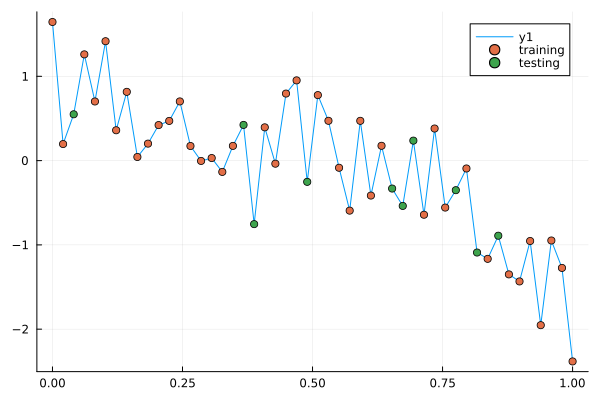

In [29]:
num_sample = 50
num_train = 40

x = range(0,1;length=num_sample)
ϵ_data = rand(Normal(0,0.5), num_sample);
y = ℯ.^(x) - 3*tan.(x) .+ ϵ_data;

plot(x,y)


indices = randcycle(rng, num_sample)
x_train = zeros(num_train)
y_train = zeros(num_train)
x_test = zeros(num_sample-num_train)
y_test = zeros(num_sample-num_train)

for (i, val) in enumerate(indices)
    if i<=num_train
        x_train[i] = x[val]
        y_train[i] = y[val]
    else
        x_test[i-num_train] = x[val]
        y_test[i-num_train] = y[val]
    end
end

scatter!(x_train ,y_train,label="training")
scatter!(x_test ,y_test,label="testing")


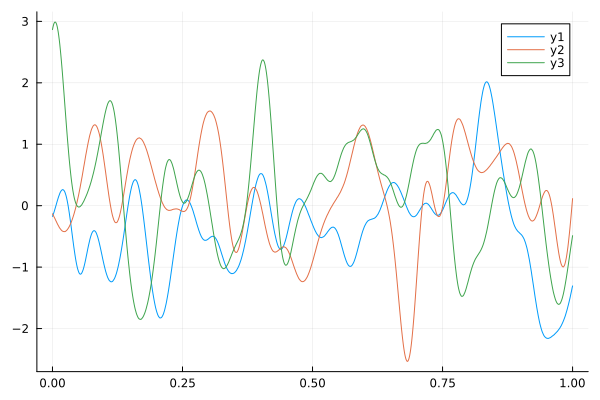

In [30]:
xs = range(0,1;length=1000)
sample_prior(xs, 3, SE_kernel_2)

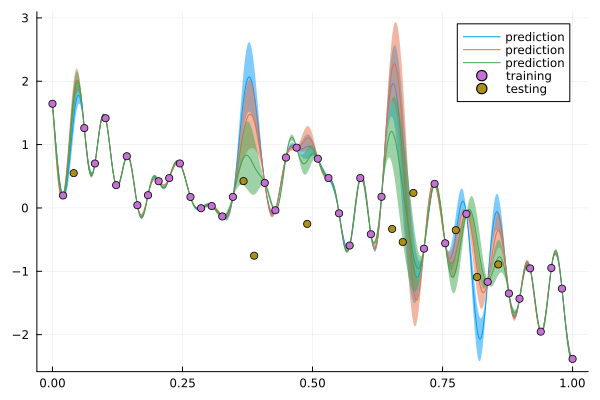

In [31]:
x_pred = range(0, 1; length=1000)
y_pred, σ_pred = sample_predictive(x_train, y_train, x_pred, 3, SE_kernel_2)

plot(x_pred, y_pred, ribbon=σ_pred, label="prediction")
scatter!(x_train ,y_train,label="training")
scatter!(x_test ,y_test,label="testing")